In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from matplotlib.dates import DateFormatter
sns.set()


def total_seconds(time):
    '''
    Convert the resolution of time to seconds
    '''
    return time.total_seconds()


# -----------------------------------------------------------------------------------
# Load the patient level table
# -----------------------------------------------------------------------------------

root_direc = "H:/Research/Hand_dirty/SAH_data"
patient = pd.read_csv(
        root_direc+"/patient_encounter/Pat_file_ENC.csv")
patient['PATIENT_SK'].nunique()                      # 4810
SAH_ENC_screened_24h_rule = pd.read_csv(
  root_direc+"/patient_encounter/SAH_ENC_screened_24h_rule.csv")
SAH_ENC_screened_24h_rule['PATIENT_SK'].nunique()    # 4810
SAH_ENC_screened_24h_rule['ENCOUNTER_ID'].nunique()  # 4823
SAH_ENC_screened_24h_rule.shape
# Get a new patient level table by adding information such as encounter ID
pat_enc_final = pd.merge(patient, SAH_ENC_screened_24h_rule, on='PATIENT_SK')
pat_enc_final.shape

(4823, 57)

In [2]:
# -----------------------------------------------------------------------------------
# Prepare the medication table
# -----------------------------------------------------------------------------------

pd.options.display.max_rows = 200
enc_med_cl2 = pd.read_csv(
   root_direc+'/medication/sah_pts_enc_med_sl_ad_cl2.tsv', delimiter='\t')
enc_med_cl2['ENCOUNTER_ID'].nunique()  # 4881
enc_med_cl2['STRENGTH_UNITS'].value_counts(dropna=False)
enc_med_cl3 = pd.read_csv(
    root_direc+'/medication/sah_pts_all_enc_med_cl3.tsv', delimiter='\t')
# In order to get the dose quantity,
# we need to merge some columns between enc_med_cl2 and enc_med_cl3
enc_med_cl2 = pd.merge(enc_med_cl2,
                       enc_med_cl3[['INDEX_ID', 'DOSE_QUANTITY']],
                       on='INDEX_ID')
enc_med_cl2['UNIT_STRENGTH'] = enc_med_cl2.eval('ORDER_STRENGTH/DOSE_QUANTITY')
enc_med_cl2['TOTAL_CONSUMED_STRENGTH'] = enc_med_cl2.eval(
                                        'UNIT_STRENGTH *CONSUMED_QUANTITY')

In [3]:
# -----------------------------------------------------------------------------------
# Combine the medication table with patient level table
# -----------------------------------------------------------------------------------

pat_enc_med = pd.merge(pat_enc_final[['PATIENT_SK', 'ENCOUNTER_ID']],
                       enc_med_cl2, on='ENCOUNTER_ID')
pat_enc_med['MED_STARTED_DT_TM'] = pd.to_datetime(
                                   pat_enc_med['MED_STARTED_DT_TM'])
pat_enc_med = pat_enc_med.sort_values(by='MED_STARTED_DT_TM')
group_by_patientsk = pat_enc_med.groupby('PATIENT_SK')

# Get the number of types of treatments one patient received
treatment_types_per_patient = group_by_patientsk['GENERIC_NAME'].nunique()

In [4]:
# -----------------------------------------------------------------------------
# Analyze medication frequency for the patient who received only one type
# of treatments. Thereafter, we only care about the observations
# with valid values of total consumed strength, deleting the NAs
# or 0s of total consumed strength
# -----------------------------------------------------------------------------

# Extract the patients who only been assigned one type of treatment
one_type_treatment = pat_enc_med[pat_enc_med['PATIENT_SK'].isin(
       treatment_types_per_patient[treatment_types_per_patient == 1].index)]
# The number of patients who only been assigned one type of treatment
one_type_treatment.shape[0]  # 5813
one_type_treatment['PATIENT_SK'].nunique()  # 3293
one_type_treatment['TOTAL_CONSUMED_STRENGTH'].describe()
# First see how many observations whose total consumed strengths are available
one_type_treatment_valid_tcs = one_type_treatment.query(
        'TOTAL_CONSUMED_STRENGTH>0')
one_type_treatment_valid_tcs.shape[0]  # 3309
one_type_treatment_valid_tcs['PATIENT_SK'].nunique()  # 1839

1839

In [5]:
# ----------------------------------------------------------------------------
# Joint analysis of Diastolic blood pressure and medication for the one type
# treatment group
# ---------------------------------------------------------------------------


def vital_signs_extract(vital_sign="Diastolic_BP"):
    '''
    This function is to extract the vital signs of those patients who have only one 
    type of vasopressor treatment
    '''
    if vital_sign in ['Diastolic_BP', 'Systolic_BP']:
        vital_sign_df = pd.read_csv(root_direc+'/vital_sign/'+vital_sign+'.csv')
    else:
        vital_sign_df = pd.read_csv(root_direc+'/vital_sign/'+vital_sign+
                                    '_cleaned.csv')
    sns.boxplot(vital_sign_df['RESULT_VALUE_NUM'])
    vital_sign_df['RESULT_VALUE_NUM'].plot.hist()
    vital_sign_df = vital_sign_df.drop('PATIENT_ID', 1)
    vital_sign_df['EVENT_DATE'] = pd.to_datetime(vital_sign_df['EVENT_DATE'])
    # Merge the vital_sign_df with patient level table
    vital_sign_df = pd.merge(vital_sign_df,
                            pat_enc_final[['PATIENT_SK', 'ENCOUNTER_ID']],
                            how='inner', on='ENCOUNTER_ID')
    # Group the vital_sign_df by patient_sk
    vital_sign_df = vital_sign_df.sort_values(by=['PATIENT_SK', 'EVENT_DATE'])
    vital_sign_df = vital_sign_df[vital_sign_df['RESULT_VALUE_NUM'].notnull()]
    one_type_treatment_patsk = one_type_treatment_valid_tcs['PATIENT_SK'].unique()
    valid_pat_sk_indc = np.in1d(
            one_type_treatment_patsk, vital_sign_df['PATIENT_SK'].unique())
    valid_pat_sk = one_type_treatment_patsk[valid_pat_sk_indc]
    return valid_pat_sk, vital_sign_df
    


# ----------------------------------------------------------------------------
# Basic summary of the vital signs
# ----------------------------------------------------------------------------


def vital_signs_summary(vital_sign_df):
    # Indicator of valid vital signs
    ind_vital_sign = vital_sign_df['PATIENT_SK'].isin(valid_pat_sk)
    valid_vital_sign = vital_sign_df[ind_vital_sign]
    # Basic summary of measurement times of blood pressure in above table
    valid_vital_sign_grpby_pat = valid_vital_sign.groupby(['PATIENT_SK'])
    # Measurement times  per patient
    meas_per_patient = valid_vital_sign_grpby_pat.size()
    meas_per_patient.describe()
    sns.boxplot(meas_per_patient)
    meas_per_patient.plot.hist(bins=100)
    # Find the maximium index
    max_meas_index = meas_per_patient.idxmax()
    max_meas_detail = valid_vital_sign[
            valid_vital_sign['PATIENT_SK'] == max_meas_index]
    return max_meas_detail

# ----------------------------------------------------------------------------
# Trend pattern of the vital sign and meanwhile the vasopressor order started time
# is anotated
# ----------------------------------------------------------------------------


# Briefly look at the trend of vital signs,
# no any processing of the date and time
def vital_sign_trend(vital_sign_df, patient_sk):
    for pat_sk in patient_sk:
        sample_vsign = vital_sign_df[vital_sign_df['PATIENT_SK'] == pat_sk]
        sample_med = one_type_treatment_valid_tcs[
            one_type_treatment_valid_tcs['PATIENT_SK'] == pat_sk]
        fig, ax = plt.subplots()
        ax.plot(sample_vsign['EVENT_DATE'], sample_vsign['RESULT_VALUE_NUM'])
        for i, val in enumerate(sample_med['MED_STARTED_DT_TM']):
            ax.axvline(x=sample_med['MED_STARTED_DT_TM'].iloc[i], alpha=0.3,
                       color='red')
            ax.text(sample_med['MED_STARTED_DT_TM'].iloc[i], ax.get_ylim()[0],
                    sample_med['GENERIC_NAME'].iloc[i], ha='center', color='red')
            ax.xaxis.set_major_locator(plt.MaxNLocator(5))
            ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))
            ax.fmt_xdata = DateFormatter('%Y-%m-%d %H:%M:%S')
            fig.autofmt_xdate()

# Zoom the picture of the trend of vital signs by looking at the
# time interval near the medication times
def vital_sign_vasop(vital_sign_df, patient_sk, threshold):
    for pat_sk in patient_sk:
        sample_vsign = vital_sign_df[vital_sign_df['PATIENT_SK'] == pat_sk]
        sample_med = one_type_treatment_valid_tcs[
            one_type_treatment_valid_tcs['PATIENT_SK'] == pat_sk]
        # Set the first of vasopressor time as the origin of the axis when plotting
        time_vsign = sample_vsign['EVENT_DATE'] - sample_med[
                'MED_STARTED_DT_TM'].iloc[0]
        time_med = sample_med['MED_STARTED_DT_TM'] - sample_med[
                'MED_STARTED_DT_TM'].iloc[0]
        # Convert the resolution of time from second to hour
        time_vsign = time_vsign.apply(total_seconds)/(60*60)
        time_med = time_med.apply(total_seconds)/(60*60)
        # We care more about the time interval near the medication time
        time_interval_interested = [time_med.iloc[0]-threshold,
                                    time_med.iloc[-1]+threshold]
        time_interested = pd.cut(time_vsign, time_interval_interested)
        vsign_interested = sample_vsign[time_interested.notnull()][
                'RESULT_VALUE_NUM']
        time_vsign = time_vsign[time_interested.notnull()]
        fig, ax = plt.subplots()
        ax.plot(time_vsign, vsign_interested)
        for i, val in enumerate(sample_med['MED_STARTED_DT_TM']):
            ax.axvline(x=time_med.iloc[i], alpha=0.3,
                       color='red')
            ax.text(time_med.iloc[i], ax.get_ylim()[0],
                    sample_med['GENERIC_NAME'].iloc[i], ha='center', color='red')

The number of patients:452


C:\Users\gzhu1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


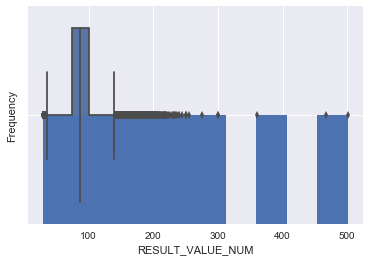

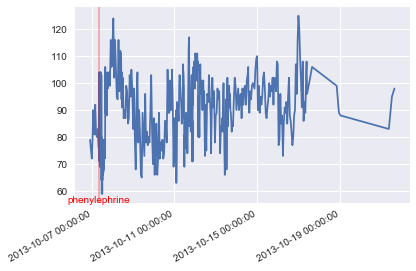

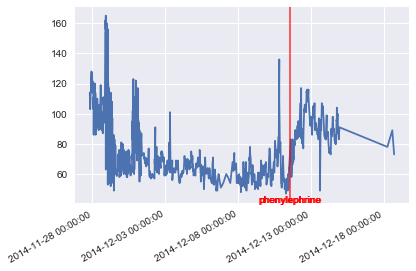

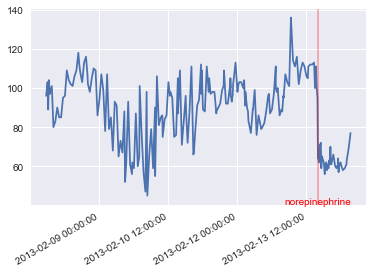

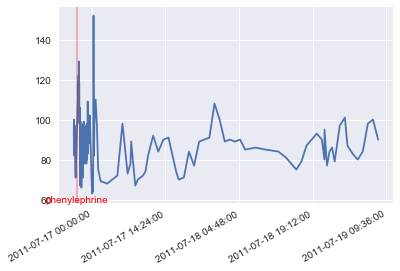

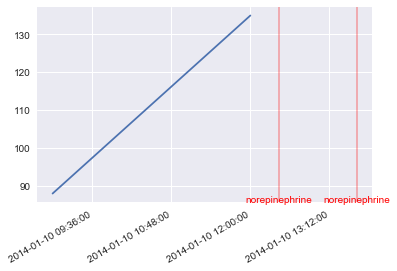

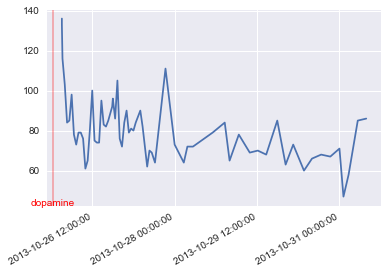

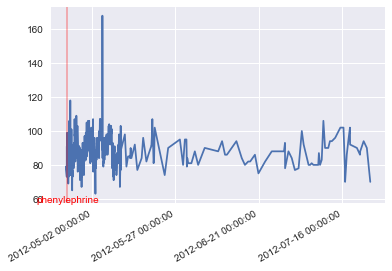

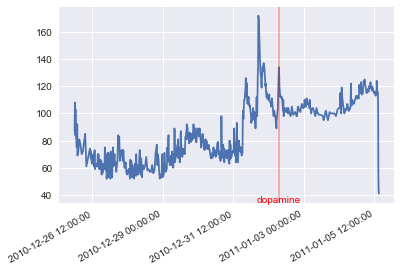

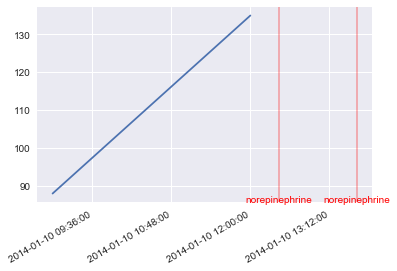

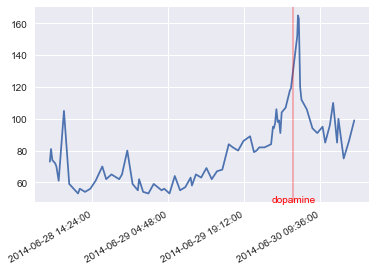

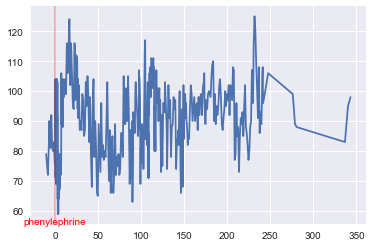

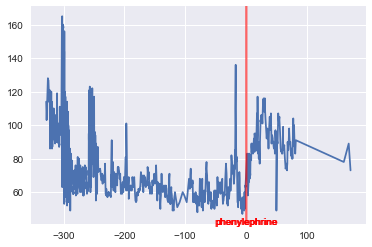

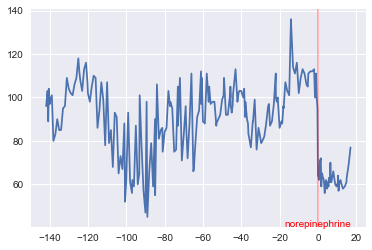

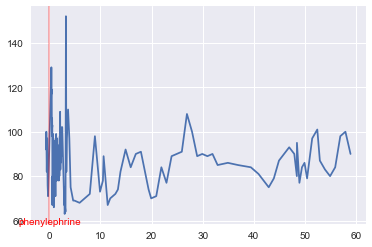

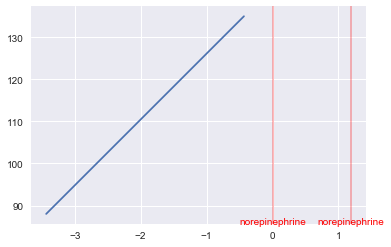

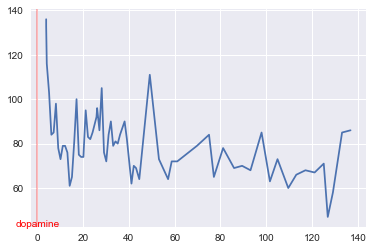

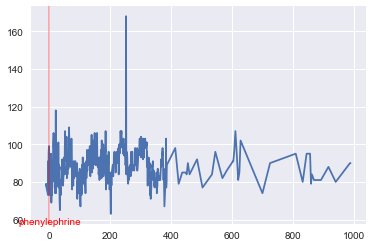

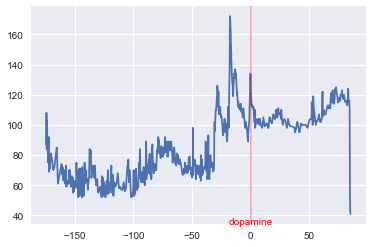

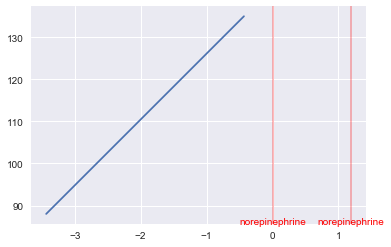

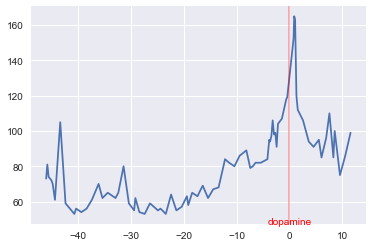

In [7]:
valid_pat_sk, vital_sign_df = vital_signs_extract("Heart_rate")
print("The number of patients:{}".format(valid_pat_sk.shape[0]))
patient_sk = np.random.choice(valid_pat_sk, 10)
vital_sign_trend(vital_sign_df, patient_sk)
vital_sign_vasop(vital_sign_df, patient_sk, threshold=1000)